In [1]:
# import os
# os.chdir("/traindata/maksim/repos/RT-DETR/rtdetr_pytorch")
# !pwd

In [2]:
# COCO classes
CLASSES = [
    'person', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'truck', 'truck', 'boat', 'fire hydrant', 'fire hydrant', 'N/A2',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'cow',
    'sheep', 'cow', 'zebra', 'giraffe', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A3', 'N/A4', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'skateboard', 'sports ball', 'kite', 'baseball bat', 'wine glass',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'bowl', 'wine glass',
    'cup', 'fork', 'orange', 'broccoli', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A6', 'dining table', 'N/A7',
    'N/A8', 'toilet', 'N/A9', 'tv', 'laptop', 'clock', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A10',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]



In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision
print(torch.cuda.is_available())
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None, classes=CLASSES):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    #unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    #image = unimage
    image = img
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{classes[label.item()]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

True


In [8]:
from argparse import Namespace
args = Namespace(config='configs/rtdetr/rtdetr_r18vd_6x_coco.yml', resume=None, 
                 tuning='rtdetr_r18vd_dec3_6x_coco_from_paddle.pth', test_only=False, amp=False, seed=None)

In [9]:
import os 
import sys
import argparse

import src.misc.dist as dist 
from src.core import YAMLConfig 
from src.solver import TASKS

dist.init_distributed()
if args.seed is not None:
    dist.set_seed(args.seed)

assert not all([args.tuning, args.resume]), \
    'Only support from_scrach or resume or tuning at one time'

cfg = YAMLConfig(
    args.config,
    resume=args.resume, 
    use_amp=args.amp,
    tuning=args.tuning
)
cfg.device = torch.device('cpu')

solver = TASKS[cfg.yaml_cfg['task']](cfg)

Not init distributed mode.


In [10]:
solver.cfg.epochs = 0

In [11]:
solver.setup()
solver.train()

Load PResNet18 state_dict
Tuning checkpoint from rtdetr_r18vd_dec3_6x_coco_from_paddle.pth
Load model.state_dict, {'missed': ['backbone.conv1.conv1_1.norm.num_batches_tracked', 'backbone.conv1.conv1_2.norm.num_batches_tracked', 'backbone.conv1.conv1_3.norm.num_batches_tracked', 'backbone.res_layers.0.blocks.0.short.norm.num_batches_tracked', 'backbone.res_layers.0.blocks.0.branch2a.norm.num_batches_tracked', 'backbone.res_layers.0.blocks.0.branch2b.norm.num_batches_tracked', 'backbone.res_layers.0.blocks.1.branch2a.norm.num_batches_tracked', 'backbone.res_layers.0.blocks.1.branch2b.norm.num_batches_tracked', 'backbone.res_layers.1.blocks.0.short.conv.norm.num_batches_tracked', 'backbone.res_layers.1.blocks.0.branch2a.norm.num_batches_tracked', 'backbone.res_layers.1.blocks.0.branch2b.norm.num_batches_tracked', 'backbone.res_layers.1.blocks.1.branch2a.norm.num_batches_tracked', 'backbone.res_layers.1.blocks.1.branch2b.norm.num_batches_tracked', 'backbone.res_layers.2.blocks.0.short.conv

In [12]:
solver.train_dataloader.dataset

Dataset CocoDetection
    Number of datapoints: 5000
    Root location: ./dataset/coco/train2017/
     img_folder: ./dataset/coco/train2017/
     ann_file: ./dataset/coco/annotations/instances_train2017.json
     return_masks: False
     transforms:
       Compose(
          RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=0.5)
          RandomZoomOut(p=0.5, fill=0, side_range=(1.0, 4.0))
          RandomIoUCrop(min_scale=0.3, max_scale=1, min_aspect_ratio=0.5, max_aspect_ratio=2, options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], trials=40, p=0.8)
          SanitizeBoundingBox(min_size=1, labels_getter=default)
          RandomHorizontalFlip(p=0.5)
          Resize(size=[640, 640], interpolation=InterpolationMode.BILINEAR, antialias=warn)
          ToImageTensor()
          ConvertDtype()
          SanitizeBoundingBox(min_size=1, labels_getter=default)
          ConvertBox(out_fmt=cxcywh, normalize=True)
    )

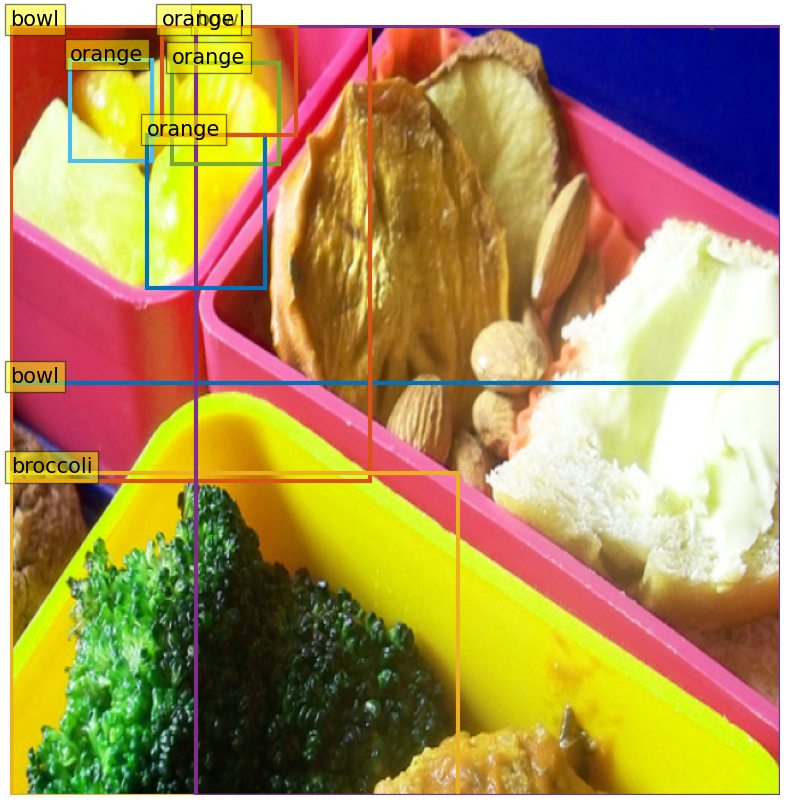

In [13]:
sample = solver.train_dataloader.dataset[0]
plot_results(sample[0], sample[1]["labels"], sample[1]["boxes"], classes=CLASSES)

In [ ]:
for batch in solver.train_dataloader:
    break
batch

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.00

In [ ]:
batch[0].shape
batch[1]

[{'boxes': tensor([[0.6069, 0.6366, 0.4797, 0.4276],
          [0.4365, 0.4559, 0.0367, 0.0293]]),
  'labels': tensor([59, 77]),
  'image_id': tensor([133]),
  'area': tensor([179829.7656,    683.9160]),
  'iscrowd': tensor([0, 0]),
  'orig_size': tensor([640, 480]),
  'size': tensor([640, 480])},
 {'boxes': tensor([[0.3415, 0.5921, 0.6770, 0.7798],
          [0.6084, 0.5563, 0.5469, 0.8874]]),
  'labels': tensor([23, 23]),
  'image_id': tensor([72]),
  'area': tensor([80168.7969, 41879.1953]),
  'iscrowd': tensor([0, 0]),
  'orig_size': tensor([427, 640]),
  'size': tensor([427, 640])},
 {'boxes': tensor([[0.1945, 0.3576, 0.0404, 0.2758],
          [0.2399, 0.3761, 0.0308, 0.2211],
          [0.1531, 0.3505, 0.0414, 0.2873],
          [0.1155, 0.3550, 0.0326, 0.2895],
          [0.0825, 0.3500, 0.0421, 0.2975],
          [0.5211, 0.7038, 0.5253, 0.5631],
          [0.9077, 0.2419, 0.1847, 0.3019],
          [0.1845, 0.7274, 0.1413, 0.0632],
          [0.1341, 0.7959, 0.1782, 0.0702],


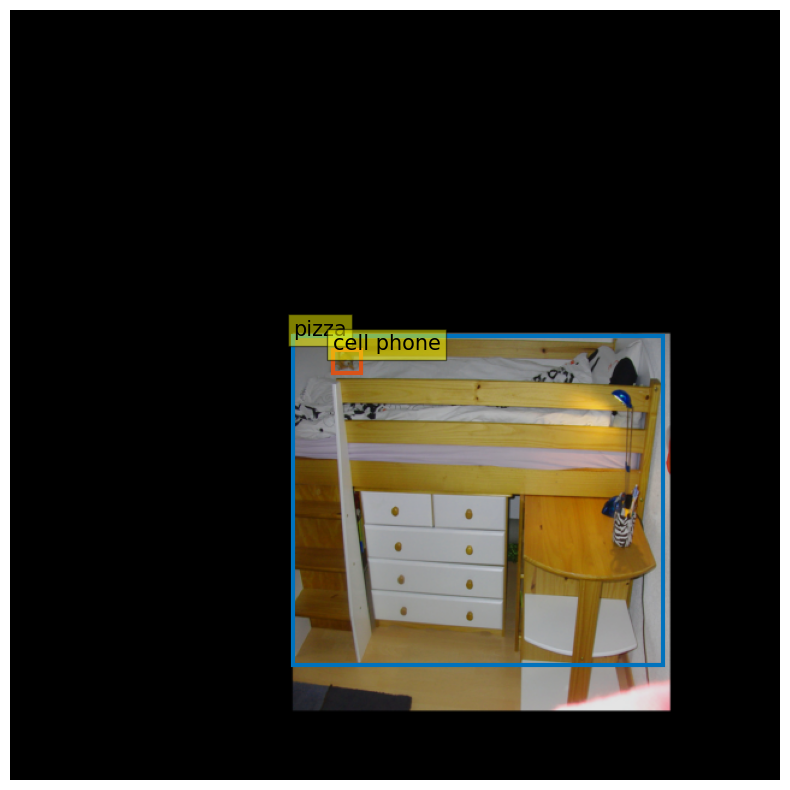

In [ ]:
batch_idx = 0
plot_results(batch[0][batch_idx], batch[1][batch_idx]["labels"], batch[1][batch_idx]["boxes"], classes=CLASSES)

In [ ]:
solver.criterion

SetCriterion(
  (matcher): HungarianMatcher()
)

In [ ]:
solver.model

RTDETR(
  (backbone): PResNet(
    (conv1): Sequential(
      (conv1_1): ConvNormLayer(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(32, eps=1e-05)
        (act): ReLU(inplace=True)
      )
      (conv1_2): ConvNormLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(32, eps=1e-05)
        (act): ReLU(inplace=True)
      )
      (conv1_3): ConvNormLayer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): FrozenBatchNorm2d(64, eps=1e-05)
        (act): ReLU(inplace=True)
      )
    )
    (res_layers): ModuleList(
      (0): Blocks(
        (blocks): ModuleList(
          (0): BottleNeck(
            (branch2a): ConvNormLayer(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm): FrozenBatchNorm2d(64, eps=1e-05)
    

In [ ]:
preds = solver.model(batch[0], batch[1])
preds

{'pred_logits': tensor([[[-4.8215, -4.9011, -5.2562,  ..., -3.7726, -4.4195, -3.5676],
          [-4.2048, -4.1436, -4.2448,  ..., -3.6313, -5.4034, -4.4324],
          [-4.4020, -4.7586, -4.9599,  ..., -4.3681, -3.4300, -4.0788],
          ...,
          [-4.6390, -4.7033, -5.3087,  ..., -3.0166, -4.6783, -4.2891],
          [-3.6118, -5.4436, -4.5206,  ..., -3.5909, -3.5560, -4.2098],
          [-4.0079, -4.0563, -4.5033,  ..., -3.7191, -4.7515, -4.8557]],
 
         [[-4.1997, -4.2214, -4.5189,  ..., -4.2734, -3.8631, -4.4210],
          [-4.5734, -4.2693, -3.7988,  ..., -4.8841, -3.7188, -4.7682],
          [-4.0638, -4.8045, -4.0876,  ..., -3.8717, -3.7311, -3.9693],
          ...,
          [-4.2148, -4.4495, -4.3845,  ..., -3.8187, -4.3683, -4.5757],
          [-4.4329, -4.1042, -4.0418,  ..., -3.7993, -3.7339, -3.5830],
          [-5.2126, -4.0191, -4.3261,  ..., -3.7680, -4.2227, -4.8994]],
 
         [[-4.2161, -3.4478, -5.3404,  ..., -3.4660, -5.5149, -4.7085],
          [-4

In [ ]:
preds['pred_logits'].shape # (batch_size, num_queries, num_classes)

torch.Size([4, 300, 80])

In [ ]:
preds['pred_boxes'].shape # (batch_size, num_queries, 4)

torch.Size([4, 300, 4])

In [ ]:
preds.keys()

dict_keys(['pred_logits', 'pred_boxes', 'aux_outputs', 'dn_aux_outputs', 'dn_meta'])

In [ ]:
print(len(list(preds['aux_outputs'])))
print(preds['aux_outputs'][0]['pred_logits'].shape)

6
torch.Size([4, 300, 80])


In [ ]:
print(len(list(preds['dn_aux_outputs'])))
print(preds['dn_aux_outputs'][0]['pred_logits'].shape)

6
torch.Size([4, 200, 80])


In [ ]:
solver.criterion(preds, batch[1])

{'loss_vfl': tensor(0.2318, grad_fn=<MulBackward0>),
 'loss_bbox': tensor(1.0195, grad_fn=<MulBackward0>),
 'loss_giou': tensor(1.9771, grad_fn=<MulBackward0>),
 'loss_vfl_aux_0': tensor(0.2037, grad_fn=<MulBackward0>),
 'loss_bbox_aux_0': tensor(1.0167, grad_fn=<MulBackward0>),
 'loss_giou_aux_0': tensor(2.0355, grad_fn=<MulBackward0>),
 'loss_vfl_aux_1': tensor(0.2472, grad_fn=<MulBackward0>),
 'loss_bbox_aux_1': tensor(1.0464, grad_fn=<MulBackward0>),
 'loss_giou_aux_1': tensor(1.9620, grad_fn=<MulBackward0>),
 'loss_vfl_aux_2': tensor(0.2594, grad_fn=<MulBackward0>),
 'loss_bbox_aux_2': tensor(1.0504, grad_fn=<MulBackward0>),
 'loss_giou_aux_2': tensor(1.9348, grad_fn=<MulBackward0>),
 'loss_vfl_aux_3': tensor(0.2670, grad_fn=<MulBackward0>),
 'loss_bbox_aux_3': tensor(1.0177, grad_fn=<MulBackward0>),
 'loss_giou_aux_3': tensor(1.9079, grad_fn=<MulBackward0>),
 'loss_vfl_aux_4': tensor(0.2605, grad_fn=<MulBackward0>),
 'loss_bbox_aux_4': tensor(0.9996, grad_fn=<MulBackward0>),
 'lo